# Processing spatial networks

Inputs
- node and edge shapefiles.

Outputs
- spatial_network_boston_miami_chicago_dic: the spatial networks of the three cities.
- spatial networks include rook, queen, 5NN, and admin-based spatial networks.

Creating the spatial networks as the local connections of the urban regions. Based on the visualization, the spatial networks are not always connected, so we have to focus on the giant components in the process of computing network parameters, e.g. diameters.


In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import copy
from scipy.sparse import csr_matrix
from pysal.lib import weights


In [3]:
# read the node files.
with open("../../data/02_intermediate/boston_miami_chicago_nyc_ct_shp_dic.pickle", 'rb') as f:
    shp_dic = pickle.load(f)

with open("../../data/02_intermediate/edge_shp_dic.pickle", 'rb') as f:
    edge_shp_dic = pickle.load(f)
    

In [4]:
# sort index
for city in shp_dic.keys():
    shp_dic[city] = shp_dic[city].sort_index()


### Create the spatial networks

In [5]:
spatial_network_dic = {}

In [6]:
from sklearn.preprocessing import OneHotEncoder

for city in shp_dic.keys():
    spatial_network_dic[city] = {}
    
    # create the queen contiguity network
    queen_contiguity = weights.contiguity.Queen.from_dataframe(shp_dic[city])
    queen_contiguity_nx = queen_contiguity.to_networkx()
    queen_contiguity_adj_m = nx.adjacency_matrix(queen_contiguity_nx).toarray()
    queen_contiguity_adj_df = pd.DataFrame(queen_contiguity_adj_m, 
                                              index = shp_dic[city].index,
                                              columns = shp_dic[city].index)
    
    # create the rook contiguity network
    rook_contiguity = weights.contiguity.Rook.from_dataframe(shp_dic[city])
    rook_contiguity_nx = rook_contiguity.to_networkx()
    rook_contiguity_adj_m = nx.adjacency_matrix(rook_contiguity_nx).toarray()
    rook_contiguity_adj_df = pd.DataFrame(rook_contiguity_adj_m, 
                                              index = shp_dic[city].index,
                                              columns = shp_dic[city].index)
        
    # create the KNN contiguity network
    _5nn_contiguity = weights.KNN.from_dataframe(shp_dic[city], k = 5)
    _5nn_contiguity_nx = _5nn_contiguity.to_networkx()
    _5nn_contiguity_adj_m = nx.adjacency_matrix(_5nn_contiguity_nx).toarray()
    _5nn_contiguity_adj_df = pd.DataFrame(_5nn_contiguity_adj_m, 
                                              index = shp_dic[city].index,
                                              columns = shp_dic[city].index)
    
    # create the county network 
    shp_dic[city]['state_county'] = shp_dic[city]['STATEFP'] + shp_dic[city]['COUNTYFP'] 
    encoder = OneHotEncoder().fit(shp_dic[city].loc[:, 'state_county'].values.reshape(-1,1))
    county_dummy = encoder.transform(shp_dic[city].loc[:, 'state_county'].values.reshape(-1,1)).toarray()
    county_adj_m = county_dummy @ county_dummy.T
    county_adj_df = pd.DataFrame(county_adj_m, 
                                 index = shp_dic[city].index,
                                 columns = shp_dic[city].index)

    # save the adjacency matrices
    spatial_network_dic[city]['queen_contiguity_adj_df'] = queen_contiguity_adj_df
    spatial_network_dic[city]['rook_contiguity_adj_df'] = rook_contiguity_adj_df
    spatial_network_dic[city]['5nn_contiguity_adj_df'] = _5nn_contiguity_adj_df
    spatial_network_dic[city]['county_adj_df'] = county_adj_df


/home/jtl/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There is 1 island with id: 477.
  warnings.warn(message)
/home/jtl/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 15 disconnected components.
 There are 3 islands with ids: 477, 581, 605.
  warnings.warn(message)
/home/jtl/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/jtl/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 1808.
  warnings.warn(message)
/home/jtl/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: U

In [7]:
spatial_network_dic['boston']['rook_contiguity_adj_df']

GEOID,25009201100,25009202101,25009202102,25009202200,25009203100,25009203200,25009203301,25009203302,25009204101,25009204102,...,33017084200,33017084300,33017084400,33017084500,33017084600,33017085000,33017086000,33017087000,33017088000,33017088500
GEOID,,,,,,,,,,,,,,,,,,,,,
25009201100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25009202101,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25009202102,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25009202200,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25009203100,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33017085000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
33017086000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
33017087000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0


## Visualize the spatial networks


In [8]:
spatial_network_dic['boston']

{'queen_contiguity_adj_df': GEOID        25009201100  25009202101  25009202102  25009202200  25009203100  \
 GEOID                                                                          
 25009201100          0.0          0.0          0.0          0.0          0.0   
 25009202101          0.0          0.0          1.0          1.0          0.0   
 25009202102          0.0          1.0          0.0          0.0          0.0   
 25009202200          0.0          1.0          0.0          0.0          1.0   
 25009203100          0.0          0.0          0.0          1.0          0.0   
 ...                  ...          ...          ...          ...          ...   
 33017085000          0.0          0.0          0.0          0.0          0.0   
 33017086000          0.0          0.0          0.0          0.0          0.0   
 33017087000          0.0          0.0          0.0          0.0          0.0   
 33017088000          0.0          0.0          0.0          0.0          0.0   
 

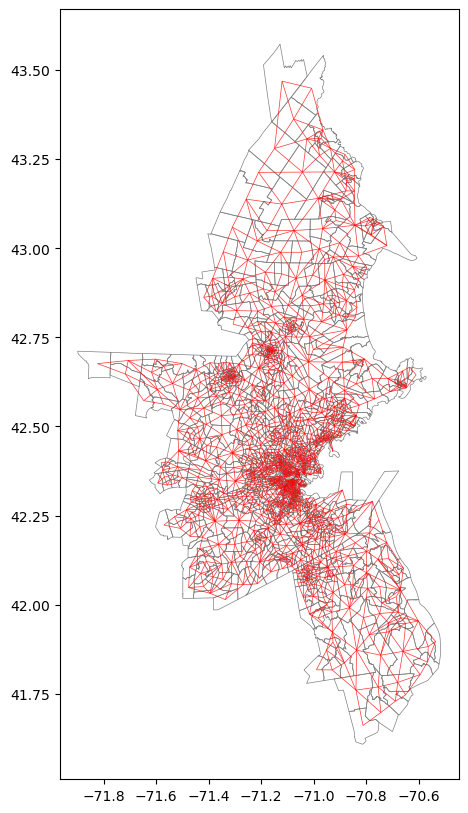

In [9]:
# Visualize the boston_queen_contiguity_adj_m network
# boston_queen_contiguity_adj_df = pd.DataFrame(boston_queen_contiguity_adj_m, 
#                                               index = df_shp.index,
#                                               columns = df_shp.index)

G = nx.from_pandas_adjacency(spatial_network_dic['boston']['queen_contiguity_adj_df'])
G_edge_df = nx.to_pandas_edgelist(G)
G_edge_df.index = list(zip(G_edge_df['source'], G_edge_df['target']))

# visualize the edge df
fig, ax = plt.subplots(figsize = (10, 10))
shp_dic['boston'].plot(facecolor='None', edgecolor='grey', ax = ax, linewidth = 0.5)
edge_shp_dic['boston'].loc[G_edge_df.index, :].plot(ax = ax, alpha = 0.8, linewidth = 0.5, color = 'red')
plt.show()


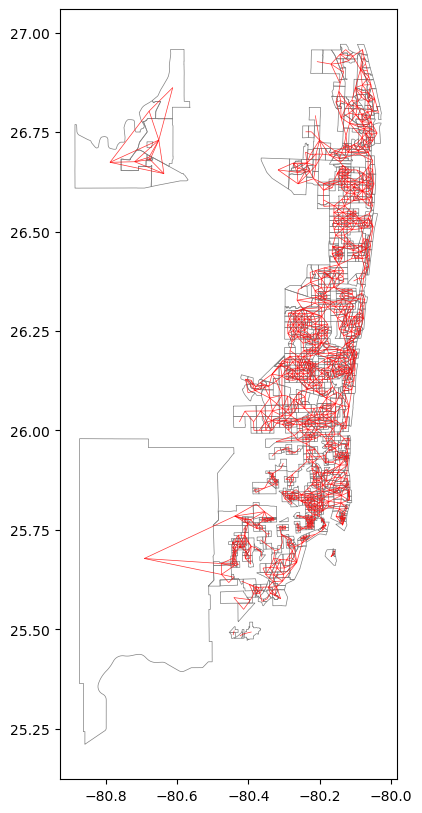

In [10]:
# miami

G = nx.from_pandas_adjacency(spatial_network_dic['miami']['queen_contiguity_adj_df'])
G_edge_df = nx.to_pandas_edgelist(G)
G_edge_df.index = list(zip(G_edge_df['source'], G_edge_df['target']))

# visualize the edge df
fig, ax = plt.subplots(figsize = (10, 10))
shp_dic['miami'].plot(facecolor='None', edgecolor='grey', ax = ax, linewidth = 0.5)
edge_shp_dic['miami'].loc[G_edge_df.index, :].plot(ax = ax, alpha = 0.8, linewidth = 0.5, color = 'red')
plt.show()


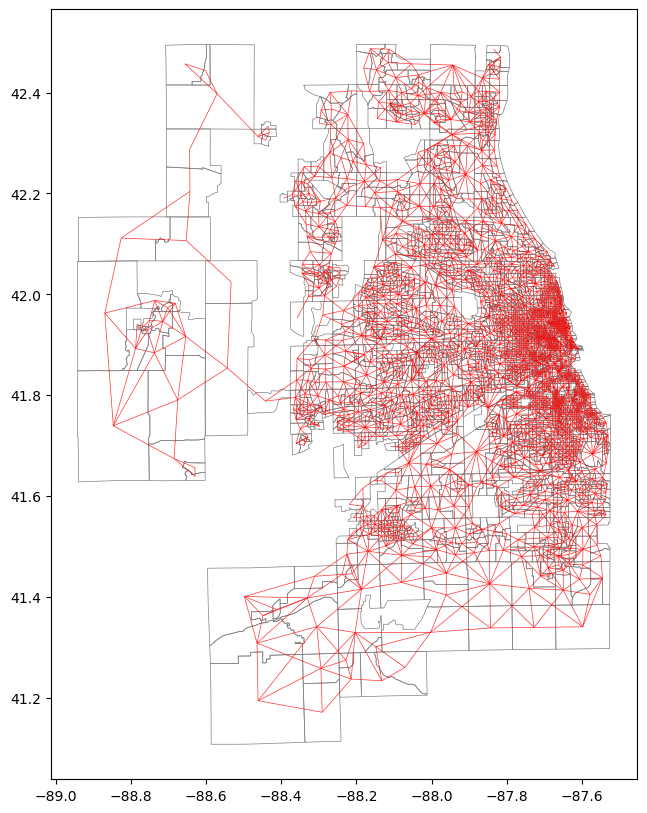

In [11]:
# chicago
G = nx.from_pandas_adjacency(spatial_network_dic['chicago']['queen_contiguity_adj_df'])
G_edge_df = nx.to_pandas_edgelist(G)
G_edge_df.index = list(zip(G_edge_df['source'], G_edge_df['target']))

# visualize the edge df
fig, ax = plt.subplots(figsize = (10, 10))
shp_dic['chicago'].plot(facecolor='None', edgecolor='grey', ax = ax, linewidth = 0.5)
edge_shp_dic['chicago'].loc[G_edge_df.index, :].plot(ax = ax, alpha = 0.8, linewidth = 0.5, color = 'red')
plt.show()


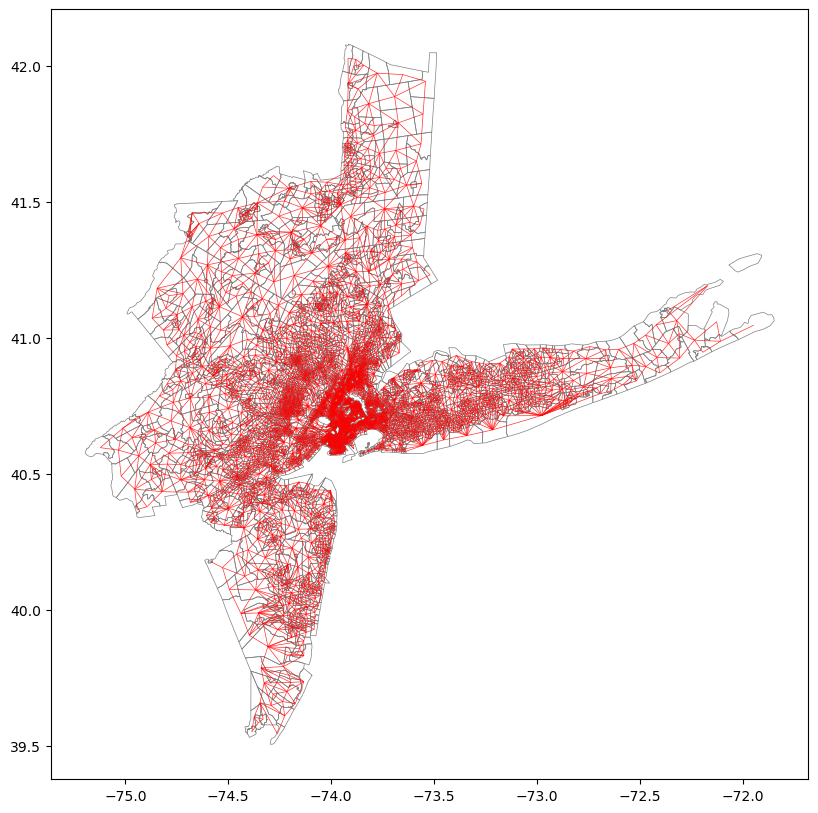

In [12]:
# nyc

G = nx.from_pandas_adjacency(spatial_network_dic['nyc']['queen_contiguity_adj_df'])
G_edge_df = nx.to_pandas_edgelist(G)
G_edge_df.index = list(zip(G_edge_df['source'], G_edge_df['target']))

# visualize the edge df
fig, ax = plt.subplots(figsize = (10, 10))
shp_dic['nyc'].plot(facecolor='None', edgecolor='grey', ax = ax, linewidth = 0.5)
edge_shp_dic['nyc'].loc[G_edge_df.index, :].plot(ax = ax, alpha = 0.8, linewidth = 0.5, color = 'red')
plt.show()


# Save

In [13]:
with open('../../data/03_processed/spatial_network_boston_miami_chicago_nyc_dic.pickle', 'wb') as f:
    pickle.dump(spatial_network_dic, f)
